In [130]:
! pip install -r ../../requirements.txt

Looking in indexes: https://pypi.org/simple, https://pip.repos.neuron.amazonaws.com


You should consider upgrading via the '/home/ec2-user/anaconda3/envs/tensorflow2_p38/bin/python -m pip install --upgrade pip' command.


In [131]:
import os
import numpy as np
import pandas as pd
import re
import time
import seaborn as sns

from os import path
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, f1_score
from sklearn.preprocessing import LabelEncoder

%matplotlib inline
import matplotlib.pyplot as plt

## 1. Reading the dataset

We will use the __pandas__ library to read our dataset. 

#### __Training data:__

In [132]:
df = pd.read_csv('../../data/programming_language_classification/data.csv', encoding='utf-8', header=0)
df.head()

,language,proj_id,file_id,file_body
0,JavaScript,10001,100001,// Functions as values of a variable\nvar cube...
1,JavaScript,10001,100002,// Functions as values of a variable\nvar cube...
2,JavaScript,10002,100003,function median(ary) {\n if (ary.length == ...
3,JavaScript,10002,100004,"[\n null,\n 4,\n 3.5,\n 2.1\n]\n"
4,JavaScript,10002,100005,(() => {\n 'use strict';\n\n // median :...


## 2. Data processing

In [133]:
# Check the class distribution of the dataset
classes = df['language'].unique()
classes.sort()
print(classes)
class_id_distribution = df['language'].value_counts()
print(class_id_distribution)

['C' 'C++' 'Fortran' 'Go' 'Haskell' 'Java' 'JavaScript' 'Julia' 'Kotlin'
 'MATLAB' 'Mathematica' 'PHP' 'Perl' 'Python' 'R' 'Ruby' 'Rust' 'Scala'
 'Swift']
Python         1452
Haskell        1333
Perl           1136
Ruby           1104
JavaScript     1104
C              1078
Go              998
Java            987
Mathematica     927
C++             880
Scala           802
Fortran         745
Kotlin          643
Julia           638
R               603
MATLAB          544
PHP             477
Rust            417
Swift           404
Name: language, dtype: int64


### 2.1 Split Training data into training and validation and process text field
Here, we split our dataset into training and validation sets and then process their text fields. 

In [134]:
print("Dropping missing values...")
print(df.shape)
df = df.dropna()
print(df.shape)

print("Splitting data into training and validation...")
X_train, X_test, y_train, y_test = train_test_split(
    df[["file_body"]],
    df["language"].values,
    test_size=0.15,
    shuffle=True,
    random_state=324,
)

X_train, X_val, y_train, y_val = train_test_split(
    X_train,
    y_train,
    test_size=0.2,
    shuffle=True,
    random_state=324,
)

def process_text(texts):
    final_text_list = []
    for sent in texts:

        filtered_sentence = []
        
        # Convert to lowercase
#         sent = sent.lower()
        # Remove leading/trailing whitespace
        sent = sent.strip()
        # Remove extra space and tabs
        sent = re.sub("\s+", " ", sent)
        # Remove numerics
#         sent = ''.join([i for i in sent if not i.isdigit()])
        
        final_text_list.append(sent)

    return final_text_list

print("Processing the text fields...")
X_train["file_body"] = process_text(X_train["file_body"].tolist())
X_val["file_body"] = process_text(X_val["file_body"].tolist())
X_test["file_body"] = process_text(X_test["file_body"].tolist())

# Regex pattern of all punctuations and letters
token_pattern = r"""([A-Za-z]*|[!\"#\$%&\'\(\)\*\+,-\./:;<=>\?@\[\\\]\^_`{\|}~])"""
# Use TD-IDF to vectorize to vectors of len 5000.
tf_idf_vectorizer = TfidfVectorizer(token_pattern = token_pattern, max_features=5000)

# Fit the vectorizer to training data
tf_idf_vectorizer.fit(X_train["file_body"].values)

print("Transforming the text fields (Bag of Words)...")
# Transform text fields
X_train = tf_idf_vectorizer.transform(X_train["file_body"].values).toarray()
X_val = tf_idf_vectorizer.transform(X_val["file_body"].values).toarray()
X_test = tf_idf_vectorizer.transform(X_test["file_body"].values).toarray()

print("Shapes of features: Training, Validation and Test")
print(X_train.shape, X_val.shape, X_test.shape)

Dropping missing values...
(16272, 4)
(16268, 4)
Splitting data into training and validation...
Processing the text fields...
Transforming the text fields (Bag of Words)...
Shapes of features: Training, Validation and Test
(11061, 5000) (2766, 5000) (2441, 5000)


### 2.2 Use the pipeline approach with random forest classifier for classification

In [135]:
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

### COLUMN_TRANSFORMER ###
##########################

train_df = pd.DataFrame(X_train)
val_df = pd.DataFrame(X_val)
# Selecting numerical features (this pipeline would work with categorical or text features too with slight modifications)
numerical_features = train_df.select_dtypes(include=np.number).columns.values.tolist()

# Preprocess the numerical features
numerical_processor = Pipeline([
    ('num_imputer', SimpleImputer(strategy='mean')),
    ('num_scaler', MinMaxScaler()) 
                                ])                            

# Combine all data preprocessors (only numerical in our case) from above
data_processor = ColumnTransformer([
    ('numerical_processing', numerical_processor, numerical_features)
])

# Visualize the data processing pipeline
from sklearn import set_config
set_config(display='diagram')
data_processor


ColumnTransformer(transformers=[('numerical_processing',
                                 Pipeline(steps=[('num_imputer',
                                                  SimpleImputer()),
                                                 ('num_scaler',
                                                  MinMaxScaler())]),
                                 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,
                                  14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24,
                                  25, 26, 27, 28, 29, ...])])

In [136]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier

### PIPELINE ###
################

# Pipeline created with all data processors, along with an estimator at the end (tried different ones but settled on random forest)
pipeline = Pipeline([
    ('data_processing', data_processor),
#     ('dt', DecisionTreeClassifier())
    ('rf', RandomForestClassifier(max_depth=150, n_estimators=300)),
#     ('mlp', MLPClassifier(learning_rate='adaptive', verbose=True, hidden_layer_sizes=(100,200,100)))
#     ('lg', LogisticRegression(solver='newton-cg', penalty='l2', C=1))
                    ])

# Visualize the pipeline
set_config(display='diagram')
pipeline


Pipeline(steps=[('data_processing',
                 ColumnTransformer(transformers=[('numerical_processing',
                                                  Pipeline(steps=[('num_imputer',
                                                                   SimpleImputer()),
                                                                  ('num_scaler',
                                                                   MinMaxScaler())]),
                                                  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9,
                                                   10, 11, 12, 13, 14, 15, 16,
                                                   17, 18, 19, 20, 21, 22, 23,
                                                   24, 25, 26, 27, 28, 29, ...])])),
                ('rf',
                 RandomForestClassifier(max_depth=150, n_estimators=300))])

In [137]:
# Fit the classifier to the train data
pipeline.fit(X_train, y_train)


Pipeline(steps=[('data_processing',
                 ColumnTransformer(transformers=[('numerical_processing',
                                                  Pipeline(steps=[('num_imputer',
                                                                   SimpleImputer()),
                                                                  ('num_scaler',
                                                                   MinMaxScaler())]),
                                                  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9,
                                                   10, 11, 12, 13, 14, 15, 16,
                                                   17, 18, 19, 20, 21, 22, 23,
                                                   24, 25, 26, 27, 28, 29, ...])])),
                ('rf',
                 RandomForestClassifier(max_depth=150, n_estimators=300))])

Model performance on the train set:
              precision    recall  f1-score   support

           C       1.00      1.00      1.00       734
         C++       1.00      1.00      1.00       583
     Fortran       1.00      1.00      1.00       515
          Go       1.00      1.00      1.00       677
     Haskell       1.00      1.00      1.00       903
        Java       1.00      1.00      1.00       662
  JavaScript       0.98      1.00      0.99       752
       Julia       1.00      1.00      1.00       443
      Kotlin       1.00      1.00      1.00       425
      MATLAB       1.00      1.00      1.00       360
 Mathematica       1.00      0.99      1.00       620
         PHP       1.00      1.00      1.00       326
        Perl       1.00      1.00      1.00       779
      Python       1.00      1.00      1.00       989
           R       1.00      1.00      1.00       430
        Ruby       1.00      1.00      1.00       739
        Rust       1.00      1.00      1.00  

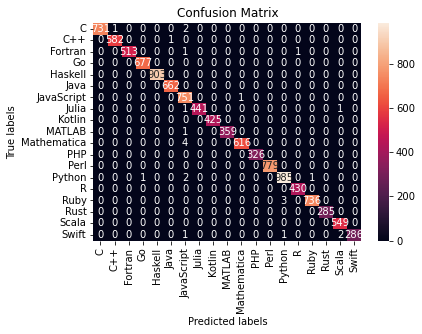

In [138]:
# Use the fitted model to make predictions on the train dataset
train_predictions = pipeline.predict(X_train)

print('Model performance on the train set:')
confusion_matrix = metrics.confusion_matrix(y_train, train_predictions)

ax= plt.subplot()
sns.heatmap(confusion_matrix, annot=True, fmt='g', ax=ax);  #annot=True to annotate cells, ftm='g' to disable scientific notation

# labels, title and ticks
ax.set_xlabel('Predicted labels');
ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(classes, rotation=90); ax.yaxis.set_ticklabels(classes, rotation=0)

print(classification_report(y_train, train_predictions))
print("Train accuracy:", accuracy_score(y_train, train_predictions))

Model performance on the validation set:
              precision    recall  f1-score   support

           C       0.92      0.89      0.90       184
         C++       0.98      0.87      0.92       160
     Fortran       0.95      0.92      0.94       103
          Go       0.97      0.93      0.95       169
     Haskell       0.92      0.90      0.91       242
        Java       0.95      0.94      0.94       167
  JavaScript       0.86      0.92      0.89       186
       Julia       0.92      0.86      0.89       100
      Kotlin       1.00      0.99      1.00       125
      MATLAB       0.88      0.91      0.89       101
 Mathematica       0.89      0.94      0.91       156
         PHP       0.96      0.92      0.94        84
        Perl       0.94      0.97      0.95       183
      Python       0.87      0.96      0.91       234
           R       0.85      0.90      0.87        88
        Ruby       0.94      0.94      0.94       200
        Rust       1.00      0.95      0

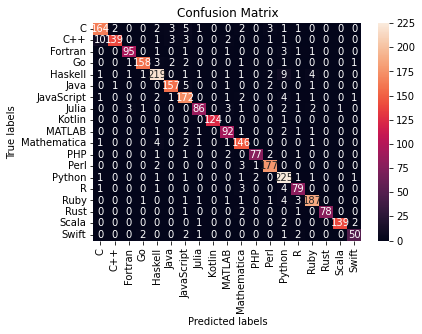

In [139]:
# Use the fitted model to make predictions on the validation dataset
val_predictions = pipeline.predict(X_val)

print('Model performance on the validation set:')
confusion_matrix = metrics.confusion_matrix(y_val, val_predictions)

ax= plt.subplot()
sns.heatmap(confusion_matrix, annot=True, fmt='g', ax=ax);  #annot=True to annotate cells, ftm='g' to disable scientific notation

# labels, title and ticks
ax.set_xlabel('Predicted labels');
ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(classes, rotation=90); ax.yaxis.set_ticklabels(classes, rotation=0)

print(classification_report(y_val, val_predictions))
print("Validation accuracy:", accuracy_score(y_val, val_predictions))

In [140]:
# Hyperparameter Tuning for reducing generalization gap
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from scipy.stats import randint as sp_randInt

### HYPERPARAMETER SEARCH ###
########################################

# Parameter grid for GridSearch (some combinations were already eliminated)
# More combinations can be tried with more time using RandomizedSearchCV
param_grid = {"rf__n_estimators" : [200,300,400],
              "rf__max_depth" : [125,150,175],
                 "rf__criterion" : ["gini"], 
                 "rf__min_samples_split" : [2], 
                 "rf__max_features" : ["log2","sqrt"]
                }

grid_search = GridSearchCV(pipeline, # Base model
                           param_grid, # Parameters to try
                           cv = 2, # Apply 2-fold cross validation
                           verbose = 1, # Print summary
                           n_jobs = -1, # Use all available processors
                          )

In [141]:
grid_search.fit(X_train, y_train)

Fitting 2 folds for each of 18 candidates, totalling 36 fits


/home/ec2-user/anaconda3/envs/tensorflow2_p38/lib/python3.8/site-packages/joblib/externals/loky/process_executor.py:702: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


GridSearchCV(cv=2,
             estimator=Pipeline(steps=[('data_processing',
                                        ColumnTransformer(transformers=[('numerical_processing',
                                                                         Pipeline(steps=[('num_imputer',
                                                                                          SimpleImputer()),
                                                                                         ('num_scaler',
                                                                                          MinMaxScaler())]),
                                                                         [0, 1,
                                                                          2, 3,
                                                                          4, 5,
                                                                          6, 7,
                                                                          8, 9,
                                                                          10,
                                                                          11,
                                                                          12,
                                                                          13,
                                                                          14,
                                                                          15,
                                                                          16,
                                                                          17,
                                                                          18,
                                                                          19,
                                                                          20,
                                                                          21,
                                                                          22,
                                                                          23,
                                                                          24,
                                                                          25,
                                                                          26,
                                                                          27,
                                                                          28,
                                                                          29, ...])])),
                                       ('rf',
                                        RandomForestClassifier(max_depth=150,
                                                               n_estimators=300))]),
             n_jobs=-1,
             param_grid={'rf__criterion': ['gini'],
                         'rf__max_depth': [125, 150, 175],
                         'rf__max_features': ['log2', 'sqrt'],
                         'rf__min_samples_split': [2],
                         'rf__n_estimators': [200, 300, 400]},
             verbose=1)

In [142]:
# Print the optimal hyperparameters and the corresponding best validation metric
print(grid_search.best_params_)
print(grid_search.best_score_)

{'rf__criterion': 'gini', 'rf__max_depth': 150, 'rf__max_features': 'sqrt', 'rf__min_samples_split': 2, 'rf__n_estimators': 400}
0.9080555985121506


In [143]:
# Get the best model out of GridSearchCV
classifier = grid_search.best_estimator_

# Fit the best model to the train data once more
classifier.fit(X_train, y_train)

Pipeline(steps=[('data_processing',
                 ColumnTransformer(transformers=[('numerical_processing',
                                                  Pipeline(steps=[('num_imputer',
                                                                   SimpleImputer()),
                                                                  ('num_scaler',
                                                                   MinMaxScaler())]),
                                                  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9,
                                                   10, 11, 12, 13, 14, 15, 16,
                                                   17, 18, 19, 20, 21, 22, 23,
                                                   24, 25, 26, 27, 28, 29, ...])])),
                ('rf',
                 RandomForestClassifier(max_depth=150, max_features='sqrt',
                                        n_estimators=400))])

Model performance on the validation set:
              precision    recall  f1-score   support

           C       0.91      0.90      0.91       184
         C++       0.99      0.86      0.92       160
     Fortran       0.94      0.91      0.93       103
          Go       0.96      0.93      0.95       169
     Haskell       0.92      0.90      0.91       242
        Java       0.96      0.93      0.95       167
  JavaScript       0.86      0.94      0.90       186
       Julia       0.94      0.84      0.89       100
      Kotlin       1.00      0.99      1.00       125
      MATLAB       0.90      0.90      0.90       101
 Mathematica       0.90      0.94      0.92       156
         PHP       0.96      0.90      0.93        84
        Perl       0.94      0.97      0.96       183
      Python       0.85      0.96      0.90       234
           R       0.87      0.89      0.88        88
        Ruby       0.92      0.93      0.93       200
        Rust       1.00      0.98      0

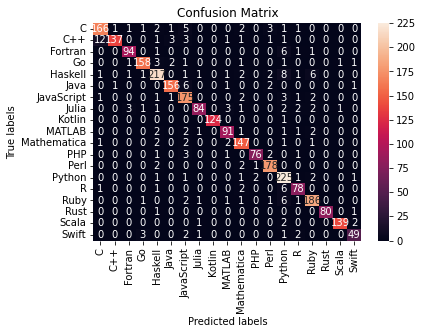

In [144]:
# Use the fitted model to make predictions on the validation dataset
val_predictions = classifier.predict(X_val)

print('Model performance on the validation set:')
confusion_matrix = metrics.confusion_matrix(y_val, val_predictions)

ax= plt.subplot()
sns.heatmap(confusion_matrix, annot=True, fmt='g', ax=ax);  #annot=True to annotate cells, ftm='g' to disable scientific notation

# labels, title and ticks
ax.set_xlabel('Predicted labels');
ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(classes, rotation=90); ax.yaxis.set_ticklabels(classes, rotation=0)

print(classification_report(y_val, val_predictions))
print("Validation accuracy:", accuracy_score(y_val, val_predictions))

### 2.3 Use a keras model implementation for classification (POC)

In [145]:
import os
import numpy as np
import pandas as pd
import re
import time
import seaborn as sns
import matplotlib.pyplot as plt

# Import required libraries
import sklearn

# Import necessary modules
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn import preprocessing
from math import sqrt

# Keras specific
import keras
from keras import regularizers
from keras.models import Sequential
from keras.layers import Dense, Dropout

In [146]:
print(X_train.shape)
print(X_val.shape)
print(y_train.shape)
print(y_val.shape)

(11061, 5000)
(2766, 5000)
(11061,)
(2766,)


In [147]:
label_encoder = preprocessing.LabelEncoder()
label_encoder.fit(y_train)

LabelEncoder()

In [148]:
# String labels are used for the random forest classifier later for testing performance on test data
y_train_str = y_train
y_val_str = y_val
y_test_str = y_test

In [149]:
print(y_train)
y_train = label_encoder.transform(y_train)
print(y_train)

['Ruby' 'Kotlin' 'Haskell' ... 'C++' 'Go' 'Mathematica']
[15  8  4 ...  1  3 10]


In [150]:
print(y_val)
y_val = label_encoder.transform(y_val)
print(y_val)

['C' 'C' 'Mathematica' ... 'Fortran' 'Ruby' 'Perl']
[ 0  0 10 ...  2 15 12]


In [151]:
print(y_test)
y_test = label_encoder.transform(y_test)
print(y_test)

['C++' 'PHP' 'Python' ... 'JavaScript' 'Mathematica' 'Rust']
[ 1 11 13 ...  6 10 16]


In [152]:
from tensorflow.keras.utils import to_categorical
y_train = to_categorical(y_train)
y_val = to_categorical(y_val)
y_test = to_categorical(y_test)
print(y_train.shape)

(11061, 19)


In [153]:
model = Sequential()
model.add(Dense(2000, kernel_regularizer=regularizers.l2(0.0003), activation='relu', input_dim=X_train.shape[1]))
model.add(Dropout(0.3))
# model.add(Dense(1000, kernel_regularizer=regularizers.l2(0.001), activation='relu'))
# model.add(Dropout(0.3))
model.add(Dense(500, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(19, activation='softmax'))

In [154]:
# Compile the model
from tensorflow.keras.optimizers import Adam
optimizer = Adam(learning_rate=0.0005)
model.compile(optimizer=optimizer, 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

In [155]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_12 (Dense)            (None, 2000)              10002000  
                                                                 
 dropout_8 (Dropout)         (None, 2000)              0         
                                                                 
 dense_13 (Dense)            (None, 500)               1000500   
                                                                 
 dropout_9 (Dropout)         (None, 500)               0         
                                                                 
 dense_14 (Dense)            (None, 19)                9519      
                                                                 
Total params: 11,012,019
Trainable params: 11,012,019
Non-trainable params: 0
_________________________________________________________________


In [156]:
# Early stopping and adaptive learning rate could be implemented here
# Hyperparameter search could also be done here on regularization constant, optimizer and batch size
model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_val, y_val))

Epoch 1/50
346/346 [==============================] - 3s 7ms/step - loss: 1.8521 - accuracy: 0.5439 - val_loss: 0.8971 - val_accuracy: 0.8395
Epoch 2/50
346/346 [==============================] - 2s 6ms/step - loss: 0.7664 - accuracy: 0.8663 - val_loss: 0.6845 - val_accuracy: 0.8803
Epoch 3/50
346/346 [==============================] - 2s 6ms/step - loss: 0.5896 - accuracy: 0.9109 - val_loss: 0.6308 - val_accuracy: 0.8952
Epoch 4/50
346/346 [==============================] - 2s 6ms/step - loss: 0.5144 - accuracy: 0.9251 - val_loss: 0.6034 - val_accuracy: 0.8930
Epoch 5/50
346/346 [==============================] - 2s 6ms/step - loss: 0.4688 - accuracy: 0.9332 - val_loss: 0.5781 - val_accuracy: 0.8999
Epoch 6/50
346/346 [==============================] - 2s 6ms/step - loss: 0.4384 - accuracy: 0.9399 - val_loss: 0.5935 - val_accuracy: 0.8944
Epoch 7/50
346/346 [==============================] - 2s 6ms/step - loss: 0.4068 - accuracy: 0.9453 - val_loss: 0.5605 - val_accuracy: 0.8973
Epoch 

In [157]:
pred_train= model.predict(X_train)
scores = model.evaluate(X_train, y_train, verbose=0)
print('Accuracy on training data: {}% \n Error on training data: {}'.format(scores[1], 1 - scores[1]))   
 
pred_val= model.predict(X_val)
scores2 = model.evaluate(X_val, y_val, verbose=0)
print('Accuracy on validation data: {}% \n Error on validation data: {}'.format(scores2[1], 1 - scores2[1]))    

Accuracy on training data: 0.988789439201355% 
 Error on training data: 0.01121056079864502
Accuracy on validation data: 0.9056398868560791% 
 Error on validation data: 0.0943601131439209


### Finally, we test predictions on the unseen test set (only once)

Model performance on the test set:
              precision    recall  f1-score   support

           C       0.88      0.90      0.89       160
         C++       0.98      0.91      0.94       137
     Fortran       0.93      0.94      0.94       127
          Go       0.97      0.93      0.95       152
     Haskell       0.94      0.93      0.93       188
        Java       0.95      0.91      0.93       158
  JavaScript       0.88      0.93      0.91       166
       Julia       0.88      0.79      0.83        94
      Kotlin       1.00      0.99      0.99        93
      MATLAB       0.88      0.89      0.89        83
 Mathematica       0.86      0.93      0.89       150
         PHP       0.97      0.93      0.95        67
        Perl       0.93      0.95      0.94       173
      Python       0.91      0.93      0.92       229
           R       0.84      0.86      0.85        85
        Ruby       0.91      0.94      0.93       165
        Rust       1.00      0.96      0.98   

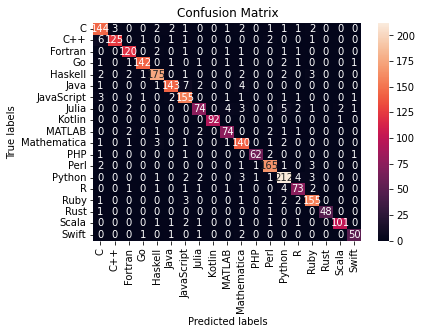

In [158]:
# Use the fitted random classifier pipeline model to make predictions on the unseen test dataset
test_predictions = pipeline.predict(X_test)

print('Model performance on the test set:')
confusion_matrix = metrics.confusion_matrix(y_test_str, test_predictions)

ax= plt.subplot()
sns.heatmap(confusion_matrix, annot=True, fmt='g', ax=ax);  #annot=True to annotate cells, ftm='g' to disable scientific notation

# labels, title and ticks
ax.set_xlabel('Predicted labels');
ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(classes, rotation=90); ax.yaxis.set_ticklabels(classes, rotation=0)

print(classification_report(y_test_str, test_predictions))
print("Test accuracy:", accuracy_score(y_test_str, test_predictions))


Model performance on the test set:
              precision    recall  f1-score   support

           C       0.89      0.90      0.89       160
         C++       0.98      0.91      0.94       137
     Fortran       0.94      0.94      0.94       127
          Go       0.98      0.95      0.96       152
     Haskell       0.93      0.94      0.93       188
        Java       0.95      0.92      0.93       158
  JavaScript       0.89      0.95      0.92       166
       Julia       0.89      0.79      0.84        94
      Kotlin       1.00      0.99      0.99        93
      MATLAB       0.86      0.89      0.88        83
 Mathematica       0.89      0.93      0.91       150
         PHP       0.94      0.91      0.92        67
        Perl       0.94      0.95      0.95       173
      Python       0.91      0.92      0.91       229
           R       0.86      0.91      0.88        85
        Ruby       0.92      0.95      0.93       165
        Rust       1.00      0.96      0.98   

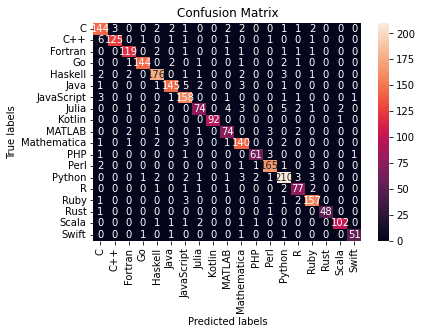

In [159]:
# Use the fitted classifer model (after hyperparameter search) to make predictions on the unseen test dataset
test_predictions = classifier.predict(X_test)

print('Model performance on the test set:')
confusion_matrix = metrics.confusion_matrix(y_test_str, test_predictions)

ax= plt.subplot()
sns.heatmap(confusion_matrix, annot=True, fmt='g', ax=ax);  #annot=True to annotate cells, ftm='g' to disable scientific notation

# labels, title and ticks
ax.set_xlabel('Predicted labels');
ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(classes, rotation=90); ax.yaxis.set_ticklabels(classes, rotation=0)

print(classification_report(y_test_str, test_predictions))
print("Validation accuracy:", accuracy_score(y_test_str, test_predictions))


In [160]:
# Use the fitted keras model to make predictions on unseen test dataset
pred_val= model.predict(X_test)
scores2 = model.evaluate(X_test, y_test, verbose=0)
print('Accuracy on test data: {}% \n Error on test data: {}'.format(scores2[1], 1 - scores2[1])) 

Accuracy on test data: 0.8963539600372314% 
 Error on test data: 0.10364603996276855
